# 1. Gaussian kernel density estimation

## Kernel density estimator
Let $\{X_1, \cdots, X_N \}$ be a set of independent realizations from an unknown continuous probability density function $f$ in a certain space $\mathcal{X} \subset \mathbb{R}$. A kernel density estimator for $f$ is defined as

$$
\begin{array}{cc}
\displaystyle \hat{f}(x; h) = \frac{1}{Nh}\sum_{i=1}^N{\kappa\left( \frac{x - X_i}{h}\right)}, & x \in \mathbb{R}
\tag{1.1}
\end{array}
$$

where the **kernel function** $\kappa$ is (usually) a symmetric density function in $\mathbb{R}$, $\kappa(-x) = \kappa(x)$. $h$ is a positive smoothing parameter called **bandwidth**. Larger values of $h$ produce smoother estimations, while lower values produce more sinuous ones. There is a bias-variance tradeoff when choosing $h$.

While both the kernel function and the bandwidth affect the performance of the density estimator, the latter is much more relevant. In practice, one usually just pick a Gaussian kernel and devotes greater effort to the choice of the smoothing parameter $h$.

## Gaussian kernel
The **Gaussian kernel density estimator** arises when $\kappa$ is the **pdf** of a standard normal distribution. Thus, the estimator is of the form

$$
 \begin{array}{cc}
  \displaystyle \hat{f}(x; h) = \frac{1}{Nh}\sum_{i=1}^N{\varphi\left( \frac{x - X_i}{h}\right)}, & x \in \mathbb{R}
 \end{array}
$$

where

$$
\displaystyle \varphi(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}
$$

Putting all the pieces together, the estimator results in

$$
 \hat{f}(x;h) = \frac{1}{Nh}\sum_{i=1}^N{\frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x - X_i}{h}\right)^2}}
$$

which can be seen as the average of $N$ normal distributions centered at each of the $X_i$ with a common standard deviation $h$

$$
 \hat{f}(x;h) = \frac{1}{N}\sum_{i=1}^N{\frac{1}{\sqrt{2\pi}h}e^{-\frac{1}{2}\left(\frac{x - X_i}{h}\right)^2}}
 \tag{1.2}
$$

In practice $x$ is just an equally spaced grid of values in an interval of the real line or the observed data.

## Error measurement

A very popular criteria to assess the performance of an estimator $\hat{f}$ is the **Mean Integrated Squared Error**

$$
\text{MISE}(\hat{f}(x; h)) = \mathbb{E}_f\int{[\hat{f}(x; h) - f(x)]^2}dx
$$

which can be decomposed in the integrated squared bias and integrated variance

$$
\text{MISE}(\hat{f}(x; h)) = \int{(\underbrace{\mathbb{E}_f[\hat{f}(x; h)] - f(x)}_{\text{pointwise bias of } \hat{f}})^2}dx + 
\int{\underbrace{Var_f(\hat{f}(x; h))}_{\text{pointwise variance of } \hat{f}}}dx
$$

In the context of a Gaussian kernel, an asymptotic first-order approximation for the **MISE** is given by

$$
\frac{1}{4} h^4 R(f'') + \frac{1}{2N\sqrt{\pi}h}
\tag{1.3}
$$

where the notation means $R(g) = \int{g(x)^2 dx}$, then $R(f'') = \lVert f'' \rVert^2 = \int{[f''(x)]^2 dx}$.

## *Optimal* bandwidth for the Gaussian KDE

It is possible to show the value of $h$ that minimizes (1.3) asymptotically is

$$
h_{\text{AMISE}} = \left(\frac{1}{2N\sqrt{\pi} R(f'')} \right)^{1 / 5}
$$

It can be observed the calculation of the optimal $h_{\text{AMISE}} $ in a Gaussian KDE requires knowing $R(f'')$, which depends on the unknown function we want to estimate.

A frequently used **Gaussian rule of thumb** is obtained by assuming that $f$ is the density of a random variable following a $\mathcal{N}(\hat{\mu}, \hat{\sigma}^2)$. In this scenario one can show that $R(f'') = \hat{\sigma}^{-5}\pi^{-1/2}3/8$ and then the rule is

$$
h_{\text{rot}} = \left(\frac{4\hat{\sigma}^5}{3N} \right)^{1/5} \approx 1.058N^{-0.2}\hat{\sigma}
$$

A more robust rule of thumb has been proposed to mitigate the effect of possible outliers and/or more serious deviations from normality

$$
h_{\text{Rot}} = \left(\frac{4A^5}{3N} \right)^{1/5}
$$

where $A = \min\{\hat{\sigma}, \frac{R}{1.34}\}$ is a robust measure of the dispersion in the observations. $R$ represents the inter-quartile range, defined as

$$
R = \underbrace{X_{([0.75N])}}_{\text{75% quantile}} - \underbrace{X_{([0.25N])}}_{\text{25% quantile}}
$$

Appart from switching from the standard deviation to the robust measure of disperion, Silverman (1986, page 48) recommends **decreasing the constant 1.058 to 0.9**. He says that with this value the mean integrated squared error is within 10% of the optimum for a variety of t-distributions, log-normals with skewness up to about 1.8 and for a normal mixture with separations up to 3 standard deviations.

In the literature, the rule $h = 1.06N^{-0.2}\hat{\sigma}$ is known as Scott's rule, and $h = 0.9AN^{-0.2}$ is known as Silverman's rule.

### **Remarks**

1. We start using a non-parametric method to estimate a density because we want to avoid the rigid structure imposed by assuming that our sample comes from a particular pre-specified distribution. We end up assuming a normal distribution to obtain a plausible rule for $h$. This usual approach is critizable at a conceptual level. 
2. Gaussian rule of thumb and robust gaussian rule of thumb can be found in Silverman, B. W. 1998, *Density Estimation for Statistics and Data Analysis*. Monographs on Statistics and Applied Probability. Chapman & Hall/CRC.
3. The computational complexity of (1.1) is $O(N^2)$.

## Naive (but straight) implementation of Gaussian KDE

In [2]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7]

BLUE = "#3498db"
DARK_BLUE = "#2980b9"
NIGHT_BLUE = "#2c3e50"

def gaussian_kde(x, h=None, grid_len=500, extend=True):
    
    """
    Naive, inefficient, but straightforward Gaussian KDE
    
    Parameters
    ----------
    x : array-like
        1 dimensional array of sample data from the variable for which a 
        density estimate is desired.
    h : float, optional
        Bandwidth (standard deviation of each Gaussian component)
        Defaults to None, which uses Gaussian robust rule of thumb.
    grid_len : int, optional
        Number of points where the kernel is evaluated. 
        Defaults to 500.
    extend: boolean, optional
        Whether to extend the domain of the observed data or not. 
        Defaults to True.
    
    Returns
    -------
    grid : Gridded numpy array for the x values.
    pdf : Numpy array for the density estimates.
    
    """
    
    x_std = np.std(x)
    x_len = len(x)
        
    if extend:
        grid_min = np.min(x) - x_std
        grid_max = np.max(x) + x_std
    else:
        grid_min = x_min
        grid_max = x_max
    
    grid = np.linspace(grid_min, grid_max, num=grid_len)
    
    pdf_mat = np.zeros((x_len, grid_len))
    
    if h is None:
        s = min(x_std, stats.iqr(x) / 1.34)
        h = 0.9 * s * x_len ** (-0.2)    
    
    for i in range(0, x_len):
        mu = x[i]
        pdf_mat[i, :] = np.exp(-0.5 * ((grid - mu) / h) ** 2) / (np.sqrt(2 * np.pi) * h)
     
    pdf = np.mean(pdf_mat, axis=0)
    
    return grid, pdf        

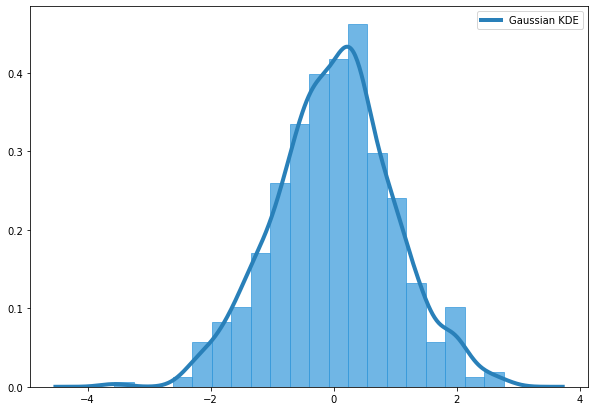

In [3]:
np.random.seed(1234)
rvs = np.random.normal(size=500)
naive_x, naive_y = gaussian_kde(rvs)

plt.plot(naive_x, naive_y, linewidth=4, color=DARK_BLUE, label="Gaussian KDE")
plt.hist(rvs, density=True, bins=20, alpha=0.7, Color=BLUE)

plt.legend()
plt.show()

# 2. Faster implementations of the Gaussian KDE

A direct implementation of the KDE usually has a computational complexity of $O(N^2)$ when the grid used for evaluation is equal to the data points. For large datasets a naive implementation is a very bad decision.

The presented alternatives are based on data binning and the Fast Fourier Transform (FFT), which allows computational speedup without a (significant) loss of accuracy.


## a. Convolution of the sample empirical distribution with a Gaussian density

### Kernel density estimate as a convolution

This section is based on [this answer](https://stats.stackexchange.com/questions/73623/kernel-density-estimation-is-a-convolution-of-what) in Stack Overflow.

Let $\{x_1, \cdots, x_N \}$ be a set of sample observations. Their sample empirical density can be written as 

$$
f_X(x) = \frac{1}{N} \sum_{i=1}^{N}{\delta(x - x_i)}
$$

Where $\delta$ is a "generalized function". Despite that name, it is not a function at all: it's a new mathematical object that can be used only within integrals. Its defining property is that for any function $g$ of compact support that is continuous in a neighborhood of $0$,

$$
\int_{\mathbb{R}}{\delta(x)g(x)dx = g(0)}
\tag{2.1}
$$

The "function" $\delta$ is sometimes known as the [Dirac delta function](https://en.wikipedia.org/wiki/Dirac_delta_function). In the following calculation this concept is extended to include functions $g$ which are continuous from one side only.

Justifying this characterization of $f_X$ is the observation that

$$
  \begin{split}
    \int_{-\infty}^{x}{f_X(y)dy} & = \int_{-\infty}^{x}{\frac{1}{N}\sum_{i=1}^{N}{\delta(y - x_i)dy}} \\
    & = \frac{1}{N}\sum_{i=1}^{N}{\int_{-\infty}^{x}{\delta(y - x_i)dy}} \\
    & = \frac{1}{N}\sum_{i=1}^{N}{\int_{\mathbb{R}}{I(y \le x)\delta(y - x_i)dy}} \\
    & = \frac{1}{N}\sum_{i=1}^{N}{I(x_i \le x)} \\
    & = F_X(x)
  \end{split}
$$

where $F_X$ is the empirical cumulative distribution function and $I$ is the indicator function.

In my opinion, the most tricky part of the previous demonstration is how to go from row 3 to row 4. That step is supported by the defining property in (2.1) seeing that $g(x)$ is $I(y \le x)$.

The convolution of $f_X(x)$ with any other function $\kappa_h$ is given, by definition, as

$$
  \begin{split}
    (f_X * \kappa)(x) & = \int_{\mathbb{R}}{f_X(x-y)\kappa_h(y)dy} \\
    & = \int_{\mathbb{R}}{\frac{1}{N}\sum_{i=1}^{N}{\delta(x - y - x_i)\kappa_h(y)dy}} \\
    & = \frac{1}{N} \sum_{i=1}^{N}{\int_{\mathbb{R}}\delta(x - y - x_i)\kappa_h(y)dy} \\
    & = \frac{1}{N} \sum_{i=1}^{N}{\kappa_h(x_i - x)} 
  \end{split}
$$

The key for the change between 3rd and 4th line is that $x - y - x_i=0$ when $y = x_i - x$ and looking to (2.1) yields the result. 

Remembering we required the kernel to be symmetric, $\kappa_h(x) = \kappa_h(-x)$, we see clearly that the kernel density estimation is a convolution between the empirical density and a kernel function.

$$
(f_X * \kappa)(x) = \frac{1}{N} \sum_{i=1}^{N}{\kappa_h(x - x_i)}
$$

### Rewriting the kernel density estimate

Recall the original formulation of the  the kernel density estimate

$$
\frac{1}{N} \sum_{i=1}^{N}{\kappa_h(x - X_i)}
$$

In practice one usually compute the KDE for equally spaced grid points $g_j$ where $j = 1, \cdots, M$, especially if $N$ is very large. For the univariate case $M \approx 500$ is sufficient in most of the scenarios. The previous equation can be rewritten as

$$
\begin{array}{cc}
\hat{f}_j \equiv \hat{f}(g_j, h) = \frac{1}{N}\sum_{i=1}^{N}{\kappa_h(g_j - X_i)}, & j = 1, \cdots, M
\end{array}
$$

Now, the number of kernel evaluations is $O(NM)$. For large $N$ this can grow too big, even for moderate $M$ such as 500.  
The next natural step could be to make use of binning. Each sample point $X_i$ is replaced by a pair of two values: the *grid point* $g_i$ and the *grid count* $c_i$.

Then, we can rewrite the kernel density estimate as follows. Note that we use $\tilde{f}$ instead of $\hat{f}$ becuse the following is an approximation.

$$
\begin{array}{cc}
\displaystyle \tilde{f}_j \equiv \tilde{f}(g_j, h, M) = \frac{1}{N} \sum_{l=1}^{M}{\kappa_h(g_j - g_l)c_l}, & j = 1, \cdots, M
\end{array}
$$

To reduce the number of multiplications $\kappa_h(\cdot) c_l$ from $O(M^2)$ to $O(M \log_2 M)$ the FFT-based technique can be used. 

How the FFT-based technique is used can be consulted in Section 5.3 of Nonparametric Kernel Density Estimation and Its Computational Aspects (Artur Gramacki, 2018) and Appendix D of Kernel Smoothing (M. P. Wand; M. C. Jones, 1994).


### Why is it faster?

You can find a lot of different resources talking about the advantages of FFT. I found [this source](https://www.dspguide.com/ch18/2.htm) helpful:

> FFT convolution uses the principle that multiplication in the frequency domain corresponds to convolution in the time domain. The input signal is transformed into the frequency domain using the DFT, multiplied by the frequency response of the filter, and then transformed back into the time domain using the Inverse DFT.  
> 
> This basic technique was known since the days of Fourier; however, no one really cared. This is because the time required to calculate the DFT was longer than the time to directly calculate the convolution.    
> 
> This changed in 1965 with the development of the Fast Fourier Transform (FFT). By using the FFT algorithm to calculate the DFT, convolution via the frequency domain can be faster than directly convolving the time domain signals. The final result is the same; only the number of calculations has been changed by a more efficient algorithm. For this reason, FFT convolution is also called high-speed convolution.



### Implementation of Convolution based Gaussian KDE

In [4]:
from scipy.signal import gaussian, convolve

def convolution_kde(x, h=None, grid_len=256, extend=True):
    
    """
    Gaussian KDE via convolution of empirical density with Gaussian signal
    
    Parameters
    ----------
    x : array-like
        1 dimensional array of sample data from the variable for which a 
        density estimate is desired.
    h : float, optional
        Bandwidth (standard deviation of each Gaussian component)
        Defaults to None, which uses Gaussian rule of thumb.
    grid_len : int, optional
        Number of points where the kernel is evaluated. 
        Defaults to 256 grid points.
    extend: boolean, optional
        Whether to extend the domain of the observed data
        or not. Defaults to True.
    
    Returns
    -------
    grid : Gridded numpy array for the x values.
    pdf : Numpy array for the density estimates.
    
    """
    
    # Calculate preliminary values
    x_len = len(x)
    x_max = np.max(x)
    x_min = np.min(x)
    x_range = x_max - x_min
    x_std = np.std(x)
    
    # Set up number of bins
    if grid_len > 512:
        grid_len = 512
    else:
        grid_len = 2 ** np.ceil(np.log2(grid_len))
    
    grid_len = int(grid_len)
    
    # Set up grid length
    if extend:
        grid_min = x_min - x_std
        grid_max = x_max + x_std
    else:
        grid_min = x_min
        grid_max = x_max
       
    # Calculate relative frequencies per bin
    f, edges = np.histogram(x, bins=grid_len, range=(grid_min, grid_max), density=True)
    
    # Bin width
    bin_width = (grid_max - grid_min) / (grid_len - 1)
    
    if h is None:
        x_std = x_std
        s = min(x_std, stats.iqr(x) / 1.34)
        h = 0.9 * s * x_len ** (-0.2) 
        
    # Bandwidth must consider the bin width
    h /= bin_width
    
    kernel = gaussian(120, h)
    pdf = convolve(f, kernel, mode="same", method="direct") / sum(kernel) # "direct" better than "fft" for n < ~ 500.
    
    grid = np.linspace(grid_min, grid_max, num=grid_len)
    # alternative
    # grid = 0.5 * (edges[1:] + edges[:-1]) 
    
    return grid, pdf

# Notes:
# Given that method="direct" is better than "fft" for n < ~ 500, it is not necessary to use a power of two for `grid_len`.

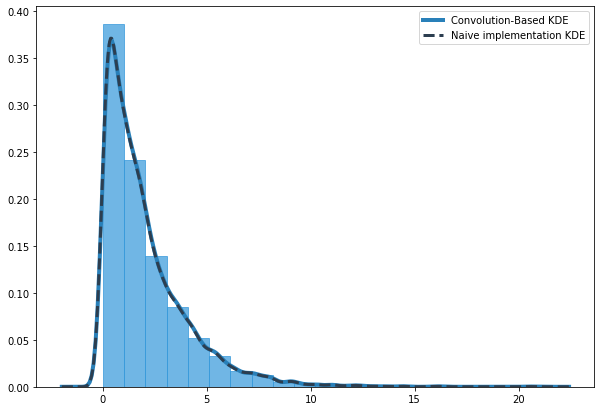

In [5]:
np.random.seed(1234)

rvs = np.random.chisquare(2, 5000)
conv_x, conv_y = convolution_kde(rvs)
naive_x, naive_y = gaussian_kde(rvs)

plt.plot(conv_x, conv_y, linewidth=4, color=DARK_BLUE, label="Convolution-Based KDE")
plt.plot(naive_x, naive_y, linestyle="--", linewidth=3, color = NIGHT_BLUE, label="Naive implementation KDE")
plt.hist(rvs, density=True, bins=20, alpha=0.7, Color=BLUE)

plt.legend()
plt.show()

Time comparisons are going to come later, but so far we see **both the naive version and the convolution based implementation result in the same estimation**.

## b. Theta function approximation to Gaussian Kernel Density Estimate

This alternative is presented in section 8.5 of Handbook of Monte Carlo Methods (D. P. Kroese; T. Taimre, Z. I. Botev, 2011) and Kernel Density Estimation via Diffusion (Z. I. Botev; J. F. Grotowski; D. P. Kroese, 2010).

Before we start let $t$ be equal to the squared bandwidth, $h^2$.  
Computational cost can be reduced by exploiting the fact that the Gaussian kernel density estimator is the solution of the Partial Differential Equation (PDE)

$$
\begin{array}{cc}
\displaystyle \frac{\partial}{\partial t}\hat{f}(x; t) = \frac{1}{2}\frac{\partial^2}{\partial x^2}\hat{f}(x; t), & t > 0
\end{array}
$$

with $x \in \mathbb{R}$, $lim_{x \to \pm \infty} \hat{f}(x; t) = 0$ and initial condition $\hat{f}(x; 0) = \Delta(x)$ where $\Delta(x) = \frac{1}{N}\sum_{i=1}^{N}{\delta_{X_i}(x)}$ is the **empirical density** of the data $X_1, \cdots, X_N$, and $\delta_{X_i}(x)$ is the Dirac measure at $X_i$. The key observation is that the presented PDE can be solved on a finite domain efficiently using a FFT-related transform.  

The procedure is as follows:

1. Without loss of generality we can consider the data to be on the unit interval $[0, 1]$. If the raw data is not on the unit interval, then it can be rescaled so that the main body of the data is in the interior of $[0, 1]$ and away from the boundaries at 0 and 1.
2. Second, the data is binned into $m$ bins, where $m$ is a power of 2 --- as required by the fastest implementations of the FFT.
3. Third, note that away from the boudaries the Gaussian kernel $\varphi_h(x) = \frac{1}{\sqrt{2\pi}h}e^{-\frac{1}{2}\left(\frac{x - X_i}{h}\right)^2}$ is approximated by the *theta function*:

$$
\begin{array}{cc}
    \theta(x, X_i; t) = \sum_{k = - \infty}^{\infty}{ \varphi(x, 2k + X_i; t) +  \varphi(x, 2k - X_i; t)} & x \in (0,1)
\end{array}
$$

The difference between the theta function and the Gaussian kernel becomes negligible as $t$ becomes smaller in the sense that

$$
\begin{array}{cc}\displaystyle
    \lim_{t\downarrow 0}{\frac{\theta(x, X_i; t)}{\varphi(x, X_i; t)} = 1}, & x \in (0, 1).
\end{array}
$$

On the other hand, the **theta kernel accounts for the boundaries** in a manner similar to the boundary correction of the *reflection method*.

It is possible to show that the theta function has the following Fourier series expansion

$$
\begin{split}
  \theta(x, X_i; t) & = 
  \begin{array}{cc} 
  \displaystyle \sum_{k = -\infty}^{\infty}{e^{-k^2\pi^2t/2}\cos(k\pi x)\cos(k\pi X_i)}, & x \in (0,1)
  \end{array} \\
  & = 1 + 2\sum_{k=1}^\infty{e^{-k^2\pi^2t/2} \cos(k\pi x)\cos(k\pi X_i)}
\end{split}
$$

Thus, on the unit interval $(0, 1)$, the Gaussian kernel density estimate can be approximated with the truncated Fourier series expansion

$$
\begin{array}{cc}
  \displaystyle \hat{f}(x; t) \approx \sum_{k=0}^{m-1}{a_k e^{-k^2\pi^2 t / 2} \cos(k\pi x)}, & N \gg 1,
\end{array}
$$

where the coefficients $\{a_k\}_{k=0}^{m - 1}$ are given by the cosine transform of the empirical data

$$
\begin{array}{ccc}
  a_0 = 1 & \displaystyle a_k = \frac{2}{N}\sum_{i=1}^{N}{\cos(k\pi X_i)}, & k = 1, 2, 3, \cdots .
\end{array}
$$

Given the binned data over the grid of size $m$, the coefficients are calculated with the fast cosine transform, a FFT related transform. Then, for a given $t$, the $\hat{f}(\cdot; t)$ are calculated using fast inverse cosine transform, where the input values are the *smoothed coefficients* $\{a_ke^{-k^2\pi^2t/2}\}_{k=0}^{m-1}$.

Hence, using the theta kernel we can evaluate $\hat{f}(\cdot; t)$ on a unfirom grid of size $m$ in $O(m \log_2 m)$ operations. This idea is summarized in the following algorithm.

**Fast evaluation of $\hat{f}(\cdot; t)$ using theta kernel**

1. Define an uniform grid of size $m$, usually a power of two:
$$
\begin{array}{cc} \displaystyle
y_k = \frac{k}{m}, & k = 0, \cdots, m
\end{array}
$$
Bin the data to compute
$$
\begin{array}{cc} \displaystyle
\hat{f_k} = \frac{\#\{X_i: X_i \in (y_k,\ y_{k+1})\}}{N}, & k = 0, \cdots, m-1.
\end{array}
$$
Thus, we have that $\hat{f_k} \approx \hat{f}(y; 0)$, $y \in (y_k, y_{k+1})$.
2. Compute the fast cosine transform $\{ \hat{f_k} \}_{k=0}^{m-1}$ of the data and let $\{ a_k\}_{k=0}^{m-1}$ be the coefficients of the fast cosine transform.
3. Let $a_k(t) = a_ke^{-k^2 \pi^2 t/2}$ for $k = 0, \cdots, m-1$.  
Compute the inverse fast cosine transform of $\{a_k(t)\}_{k=0}^{m-1}$, so that we obtain the (approximate) values of $\hat{f}(\cdot;t)$ over the uniform grid.

### Implementation of theta KDE

In [6]:
from scipy.fftpack import fft, ifft # faster than np.fft.fft and np.fft.ifft

# -------------------------------------------------------------------------------------
def _dct1d(x):
    
    """
    Discrete Cosine Transform in 1 Dimension
    
    Parameters
    ----------
    x : array-like
        1 dimensional array of values for which the 
        DCT is desired
        
    Returns
    -------
    output : DTC transformed values
    """

#     x = np.asfarray(x, dtype='float')
    x_len = len(x)

    even_increasing = np.arange(0, x_len, 2)
    odd_decreasing = np.arange(x_len - 1, 0, -2)

    x = np.concatenate((x[even_increasing], x[odd_decreasing]))
    
    w_1k = np.r_[1, (2 * np.exp(-(0 + 1j) * (np.arange(1, x_len)) * np.pi / (2 * x_len)))]
    output = np.real(w_1k * fft(x))
    
    return output

# -------------------------------------------------------------------------------------
def _idct1d(x):
    
    """
    Inverse Discrete Cosine Transform in 1 Dimension
    
    Parameters
    ----------
    x : array-like
        1 dimensional array of values for which the 
        IDCT is desired
        
    Returns
    -------
    output : IDCT transformed values
    """

#     x = np.asfarray(x, dtype='float')
    x_len = len(x)

    w_2k = x * np.exp((0 + 1j) * np.arange(0, x_len) * np.pi / (2 * x_len))
    x = np.real(ifft(w_2k))

    output = np.zeros(x_len)
    output[np.arange(0, x_len, 2, dtype=int)] = x[np.arange(0, x_len / 2, dtype=int)]
    output[np.arange(1, x_len, 2, dtype=int)] = x[np.arange(x_len - 1, (x_len / 2) - 1, -1, dtype=int)]

    return output

# --------------------------------------------------------------------------------------------------------
def theta_kde(x, h=None, grid_len=256, extend=True):
    
    """
    Approximation to Gaussian KDE via Theta kernel
    
    Parameters
    ----------
    x : array-like
        1 dimensional array of the observed data for which a 
        density estimate is desired.
    h : float, optional
        Bandwidth (standard deviation of each Gaussian component)
        Defaults to None, which uses gaussian rule of thumb.
    grid_len : int, optional
        Number of points where the kernel is evaluated. 
        Defaults to 256 grid points.
    extend: bool, optional
        Whether to extend the domain of the observed data
        or not. Defaults to True.
    
    Returns
    -------
    grid : Gridded numpy array for the x values.
    pdf : Numpy array for the density estimates.
    
    """

    # Calculate preliminary values
    x_len = len(x)
    x_max = np.max(x)
    x_min = np.min(x)
    x_range = x_max - x_min
    x_std = np.std(x)
    
    # Set up number of bins
    if grid_len > 512:
        grid_len = 512
    else:
        grid_len = 2 ** np.ceil(np.log2(grid_len))
    
    grid_len = int(grid_len)
    
    # Set up grid range
    if extend:
        grid_min = x_min - x_std
        grid_max = x_max + x_std
    else:
        grid_min = x_min
        grid_max = x_max
          
    # Relative frequency per bin
    f, edges = np.histogram(x, bins=grid_len, range=(grid_min, grid_max), density=True)

    # Discrete cosine transform of the data
    a_k = _dct1d(f)

    # Bandwidth selection
    if h is None:
        s = min(x_std, stats.iqr(x) / 1.34)
        t = 1.12 * s ** 2 * x_len ** (-0.4) # 1.12 could be replaced with 0.9^2 according to Silverman.
    else:
        t = float(h) ** 2
    
    t = t / x_range ** 2

    # Smooth values obtained with the DCT
    a_k = a_k * np.exp(-np.arange(0, grid_len) ** 2 * np.pi ** 2 * t * 0.5)

    # Inverse discrete cosine transform
    density = _idct1d(a_k)

    grid = np.linspace(grid_min, grid_max, num=grid_len)
    # alternative
    # grid = 0.5 * (edges[1:] + edges[:-1]) 

    return grid, density

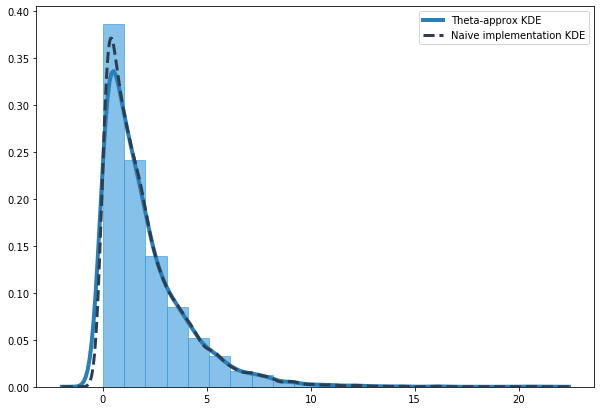

In [7]:
np.random.seed(1234)

rvs = np.random.chisquare(2, 5000)
theta_x, theta_y = theta_kde(rvs)
naive_x, naive_y = gaussian_kde(rvs)

plt.plot(theta_x, theta_y, linewidth=4, color=DARK_BLUE, label="Theta-approx KDE")
plt.plot(naive_x, naive_y, linestyle="--", linewidth=3, color=NIGHT_BLUE, label="Naive implementation KDE")
plt.hist(rvs, density=True, bins=20, alpha=0.6, Color=BLUE)

plt.legend()
plt.show()

Given the theta KDE is an approximation to the Gaussian KDE, we expected to see minor differences between the two estimations.

# 3. Time comparisons

In [8]:
import datetime
from timeit import default_timer as timer

def iterator(f, x, loops=40):
    start = timer()
    for i in range(0, loops):
        f(x)
    end = timer()
    return ((end - start) / loops)

In [9]:
np.random.seed(1234)
sizes = [1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000, 60000]

time_naive = []
time_convolution = []
time_theta = []

for i in range(0, len(sizes)):
    
    size = sizes[i]
    data = stats.norm.rvs(size=int(size))

    time_naive.append(iterator(gaussian_kde, data))
    time_convolution.append(iterator(convolution_kde, data))
    time_theta.append(iterator(theta_kde, data))
    
    print("Size " + str(size) + " done.")

Size 1000 done.
Size 2000 done.
Size 5000 done.
Size 10000 done.
Size 20000 done.
Size 30000 done.
Size 40000 done.
Size 50000 done.
Size 60000 done.


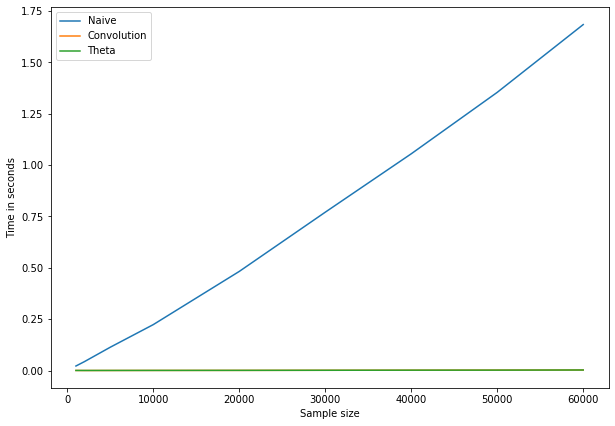

In [10]:
plt.plot(sizes, time_naive, label="Naive")
plt.plot(sizes, time_convolution, label="Convolution")
plt.plot(sizes, time_theta, label="Theta")
plt.xlabel("Sample size")
plt.ylabel("Time in seconds")

plt.legend()
plt.show()

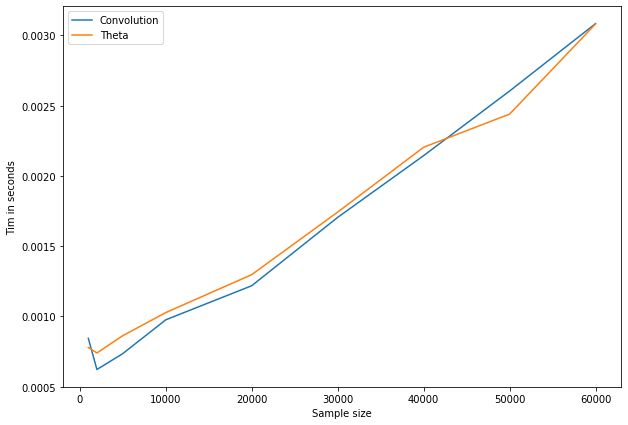

In [11]:
plt.plot(sizes, time_convolution, label="Convolution")
plt.plot(sizes, time_theta, label="Theta")
plt.xlabel("Sample size")
plt.ylabel("Tim in seconds")

plt.legend()
plt.show()

In [23]:
print(np.around(time_convolution, 6))
print(np.around(time_theta, 6))
print(np.around(np.array(time_convolution) / np.array(time_theta), 6))

[0.000844 0.000623 0.000735 0.000976 0.001218 0.001705 0.002144 0.002604
 0.003084]
[0.000779 0.00074  0.000863 0.001027 0.001297 0.001742 0.002204 0.00244
 0.003081]
[1.083106 0.841078 0.852079 0.949873 0.939231 0.978382 0.97301  1.067266
 1.000846]


The implementation via the convolution has a better performance but both methods tend to perform similarly as the sample size gets larger.

# Appendix

## Discrete Cosine Transform (DCT)

The discrete cosine transform is important in signal processing due to its property of compressing very well data that is highly correlated.

Let $x_0, \cdots, x_{N-1}$ be a sequence of real numbers. The **discrete cosine transform** is defined as the sequence

$$
\begin{array}{cc}
\displaystyle y_k=\alpha_k\sum_{n=0}^{N-1}{x_n\cos\left(\frac{\pi(2n+1)k}{2N}\right)}, & 0 \le k \le N-1,
\end{array}
$$

where $\alpha_0 =1$ y $\alpha_k = 2,\ k \ge 1$. The **inverse discrete cosine transform** returns back to the original sequence:

$$
\begin{array}{cc}
\displaystyle x_n = \frac{1}{N}\sum_{k=0}^{N-1}{y_k\cos\left(\frac{\pi(2n+1)k}{2N}\right)}, & 0 \le n \le N-1
\end{array}
$$

Note the discrete cosine transform is not the real part of the discrete Fourier transform. However, the Fast Fourier transform (FFT) can be used to calculate the discrete cosine transform in $O(N\log_2{N})$ operations as shown below. For simplicity, let's assume that $N$ is an even integer. For the fastest performance one has to use $N = 2 ^ m$, for some integer $m$.

### Algorithm A.1 (Fast Cosine Transform)

To quickly calculate the discrete cosine transform of a sequence $x_0, \cdots, x_{N-1}$, execute the following steps:

1. Define the re-ordered sequence $\tilde{x}_0, \cdots, \tilde{x}_{N-1}:$  
$$
\left(x_0, x_2, x_4, \cdots, x_{N-6}, x_{N-4}, x_{N-2}, x_{N-1}, x_{N-3}, x_{N-5}, \cdots, x_5, x_3, x_1 \right)
$$  
such that
$$
\begin{array}{c}
\tilde{x}_n = x_{2n}, \\
\tilde{x}_{N-n-1} = x_{2n+1}, \\
\end{array}
$$
where $n$ satisfies $0 \le n \le \frac{N}{2} -1$

2. Compute the discrete Fourier transform (recall that $\omega = \exp(-2\pi i/N)$):
$$
\begin{array}{c c}
\displaystyle z_k = \sum_{n=0}^{N-1}{\tilde{x}_n\omega^{kn}}, & 0 \le k \le N-1
\end{array}
$$
of the sequence $\tilde{x}_0, \cdots, \tilde{x}_{N-1}$ via FFT (using an implementation in `C` or another language).

3. Get real part of the sequence $\{\alpha_kz_ke^{-i\pi k / (2N)}\}:$
$$
\begin{array}{c c}
y_k = \mathbb{R}\left[\alpha_kz_ke^{-i\pi k / (2N)}  \right], & 0 \le k \le N-1
\end{array}
$$

<!--- Por una cuestión de consistencia con la implementación en `R`, notamos $w_{1,k} = \alpha_ke^{-i\pi k/(2N)}$ --->

### Implementation of Fast Discrete Cosine Transform in Python

See `_dct1d()` above.

### Algorithm A.2 (Fast Inverse Discrete Cosine Transform)  

To quickly calculate the inverse discrete cosine transform of a sequence $y_0, \cdots, y_{N-1}$, execute the following steps:

1. Compute the inverse discrete Fourier transform 
$$
\begin{array}{c c}
\displaystyle z_n = \frac{1}{N}\sum_{k=0}^{N-1}{\left[y_ke^{i\pi k /(2N)}\right] \omega^{-kn}}, & 0 \le n \le N-1
\end{array}
$$
of the sequence $\{w_{2,k} = y_ke^{i\pi k /(2N)}\}$ using inverse FFT.
2. Obtain the re-ordered sequence $x_1, \cdots, x_{N-1}$ of real numbers:
$$
\begin{array}{c}
x_{2n} = \mathbb{R}[z_n], \\
x_{2n+1} = \mathbb{R}[z_{2(N-n-1)}],
\end{array}
$$
where $0 \le n \le \frac{N}{2}-1$, as the inverse discrete cosine transform of the sequence $y_1, \cdots, y_{N-1}$.

### Implementation of Inverse Fast Discrete Cosine Transform in Python

See `_idct1d()` above.

## Fourier Transform (for personal reminder)

\*Only valid for `R`. Must check if Python implementation is the same.

In this section we try to briefly describe what is calculated each time the function `fft` is called in` R`.
The `fft` function computes the Discrete Fourier Transform **(DFT)** of a vector using a fast algorithm, **FFT**. The function `fft` is implemented in `C`.

### Discrete Fourier Transform (DFT)

Given a vector `x`, the` fft` function calculates the discrete *univariate* and *non-normalized* Fourier transform of the sequence of values in `x`.  
Specifically, `X <- fft (x)` results in

$$
X_h = \sum_{k=0}^{N-1} x_ke^{-\frac{2\pi i}{N}hk}
$$

for $h = 0, \cdots, N-1$ and `N = length(X)`.

### Inverse Discrete Fourier Transform (IDFT)

When `inverse = TRUE` is specified, the` fft` function calculates the inverse Fourier transform (without normalizing). The representation of the calculation is similar to the previous case, with the difference that $\exp (-2 \pi \cdots)$ is replaced with $\exp (2\pi \cdots)$

$$
X_h = \sum_{k=0}^{N-1} x_ke^{\frac{2\pi i}{N}hk}
$$

for $h = 0, \cdots, N-1$ and `N = length(X)`.

**Note:** What is known in the literature as a discrete Fourier Inverse Transform (IDFT) is the previous result multiplied by $1/N$.

### Fast Discrete Fourier Transform

Returning to the case of **DFT** we can see that this operation requires $N$ complex multiplications and $N-1$ complex sums for every $h$.

$$
\begin{array} {ccl}
   & O(N^2)       & \text{computations for direct DFT} \\
vs &              & \\
   & O(N\log (N)) & \text{computations for FFT}
\end{array}
$$

FFT uses the symmetries of $e^{-\frac{2\pi i}{N}hk}$.

Let $W_N = e^{-\frac{2\pi i}{N}}$. Two important properties are: 

1. Complex conjugate symmetry: $W_N^{h(N-n)} = W_N^{-hn}= (W_N^{hn})^*$
2. Periodicity in $n$ and $h$: $W_N^{hn} = W_N^{k(N+n)} = W_N^{(k+N)n}$

Then, from both properties you can see that
$$
W_N^{kN} = e^{-2\pi ih} = 1
$$

One of the most popular algorithms for implementing FFT is the one proposed by Cooley and Tukey. This is called **radix-2 decimation-in-time** FFT. The algorithm divides a DFT of size $N$ into two interleaved DFTs of size $N / 2$ recursively (hence the name radix-2).

- Builds the entire DFT from smaller DFTs
- Assumes that $N=2^m$ with $m$ natural number.

Consider separating the sequence $x_0, \cdots, x_{N-1}$ into two sub-sequences, one indexed by even numbers and the other by odd numbers. Then

$$
X_h = \sum_{r=0}^{\frac{N}{2} -1}{X_{2r}}W_N^{h2r} + \sum_{r=0}^{\frac{N}{2} -1}{X_{2r+1}}W_N^{h(2r+1)}
$$ 
